# percent-allocate

Maintain a percent allocation of a security in account

In [1]:
# use future imports for python 3.x forward compatibility
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import

# other imports
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

# project imports
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

In [3]:
pf.DEBUG = False

Some global data

In [4]:
#symbol = '^GSPC'
symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

Define target_percent and band

In [5]:
target_percent = 50
band = 3

sma200_band = 3.5/100

Define Strategy Class 

In [6]:
class Strategy(object):

    def __init__(self, symbol, capital, start, end):
        self._symbol = symbol
        self._capital = capital
        self._start = start
        self._end = end

    def _algo(self):
        self._tlog.cash = self._capital
        start_flag = True
        end_flag = False

        for i, row in enumerate(self._ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high
            low = row.low
            close = row.close
            sma200 = row.sma200
            end_flag = True if (i == len(self._ts) - 1) else False
            shares = 0

            if pd.isnull(sma200) or date < self._start:
                continue
            elif start_flag:
                start_flag = False
                # set start and end
                self._start = date
                self._end = self._ts.index[-1]

            # adjust shares
            if ((self._tlog.percent(close) > target_percent+band or
                self._tlog.percent(close) < target_percent-band)
                and close > sma200*(1+sma200_band)
                and not end_flag):
                # adjust shares to target_percent
                shares = self._tlog.adjust_percent(date, close, target_percent)   
            # close out
            elif (close < sma200*(1-sma200_band)
                  or end_flag):
                # adjust shares to 0
                shares = self._tlog.adjust_percent(date, close, 0)

            if shares > 0:
                pf.DBG("{0} BUY  {1} {2} @ {3:.2f}".format(
                       date, shares, self._symbol, close))
            elif shares < 0:
                pf.DBG("{0} SELL {1} {2} @ {3:.2f}".format(
                       date, -shares, self._symbol, close))

            # record daily balance
            self._dbal.append(date, high, low, close,
                              self._tlog.shares, self._tlog.cash)

    def run(self):
        self._ts = pf.fetch_timeseries(self._symbol)
        self._ts = pf.select_tradeperiod(self._ts, self._start, self._end,
                                         use_adj=True, pad=False)

        # Add technical indicator: 200 day sma
        sma200 = SMA(self._ts, timeperiod=200)
        self._ts['sma200'] = sma200

        self._tlog = pf.TradeLog()
        self._dbal = pf.DailyBal()

        self._algo()

    def get_logs(self):
        """ return DataFrames """
        self.rlog = self._tlog.get_log_raw()
        self.tlog = self._tlog.get_log()
        self.dbal = self._dbal.get_log(self.tlog)
        return self.rlog, self.tlog, self.dbal

    def get_stats(self):
        stats = pf.stats(self._ts, self.tlog, self.dbal,
                         self._start, self._end, self._capital)
        return stats

Run Strategy

In [7]:
s = Strategy(symbol, capital, start, end)
s.run()

Retrieve log DataFrames

In [8]:
rlog, tlog, dbal = s.get_logs()
stats = s.get_stats()

In [9]:
rlog.tail(10)

,date,price,shares,entry_exit
32,2014-02-27,165.97,6,exit
33,2015-02-13,191.04,5,exit
34,2015-08-21,181.84,79,exit
35,2016-04-01,193.31,76,entry
36,2017-02-13,220.99,5,exit
37,2017-11-28,253.13,5,exit
38,2018-10-29,258.72,66,exit
39,2019-03-18,279.67,61,entry
40,2019-12-16,319.50,4,exit
41,2019-12-19,320.90,57,exit


In [10]:
tlog.tail(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total
22,2012-01-10,110.60,2012-09-13,126.76,16.16,113.11,7,12950.56
23,2012-01-10,110.60,2013-05-14,145.30,34.70,208.21,6,13158.77
24,2012-01-10,110.60,2014-02-27,165.97,55.37,332.22,6,13490.99
25,2012-01-10,110.60,2015-02-13,191.04,80.43,402.17,5,13893.16
26,2012-01-10,110.60,2015-08-21,181.84,71.24,5627.58,79,19520.74
27,2016-04-01,193.31,2017-02-13,220.99,27.68,138.40,5,19659.14
28,2016-04-01,193.31,2017-11-28,253.13,59.81,299.07,5,19958.22
29,2016-04-01,193.31,2018-10-29,258.72,65.41,4316.86,66,24275.08
30,2019-03-18,279.67,2019-12-16,319.50,39.83,159.31,4,24434.39
31,2019-03-18,279.67,2019-12-19,320.90,41.23,2350.00,57,26784.39


In [11]:
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2019-12-13,36653.96,36492.31,36571.61,61,17215.09,-
2019-12-16,36741.64,36576.34,36704.59,57,18493.09,X
2019-12-17,36747.34,36703.45,36708.58,57,18493.09,-
2019-12-18,36747.34,36706.30,36709.72,57,18493.09,-
2019-12-19,36784.39,36784.39,36784.39,0,36784.39,X


Generate strategy stats - display all available stats

In [12]:
pf.print_full(stats)

start                                                  1993-11-11
end                                                    2019-12-19
beginning_balance                                           10000
ending_balance                                           36784.39
total_net_profit                                         26784.39
gross_profit                                             26990.64
gross_loss                                                -206.25
profit_factor                                              130.86
return_on_initial_capital                                  267.84
annual_return_rate                                           5.12
trading_period                           26 years 1 months 8 days
pct_time_in_market                                          75.57
total_num_trades                                               32
trades_per_year                                              1.23
num_winning_trades                                             31
num_losing

Run Benchmark

In [13]:
benchmark = pf.Benchmark(symbol, capital, s._start, s._end)
benchmark.run()

1993-11-11 00:00:00 BUY  215 SPY @ 46.38
2019-12-19 00:00:00 SELL 215 SPY @ 320.90


Retrieve benchmark logs

In [14]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [15]:
benchmark.stats = benchmark.get_stats()
pf.print_full(benchmark.stats)

start                                                  1993-11-11
end                                                    2019-12-19
beginning_balance                                           10000
ending_balance                                           69022.87
total_net_profit                                         59022.87
gross_profit                                             59022.87
gross_loss                                                   0.00
profit_factor                                                1000
return_on_initial_capital                                  590.23
annual_return_rate                                           7.68
trading_period                           26 years 1 months 8 days
pct_time_in_market                                         100.00
total_num_trades                                                1
trades_per_year                                              0.04
num_winning_trades                                              1
num_losing

Plot Equity Curves: Strategy vs Benchmark

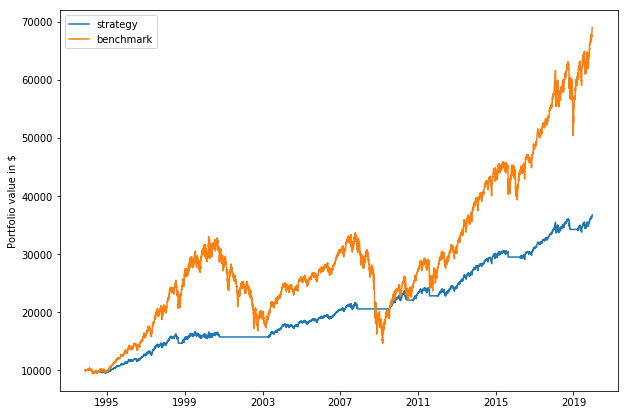

In [16]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

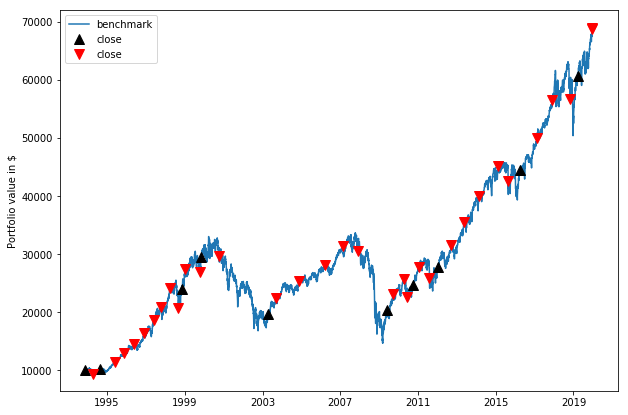

In [17]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,5.12,7.68
max_closed_out_drawdown,-10.11,-56.42
drawdown_annualized_return,-1.98,-7.35
drawdown_recovery,-0.30,-1.42
best_month,7.56,22.70
worst_month,-6.85,-29.78
sharpe_ratio,0.84,0.50
sortino_ratio,0.96,0.64
monthly_std,1.53,4.32


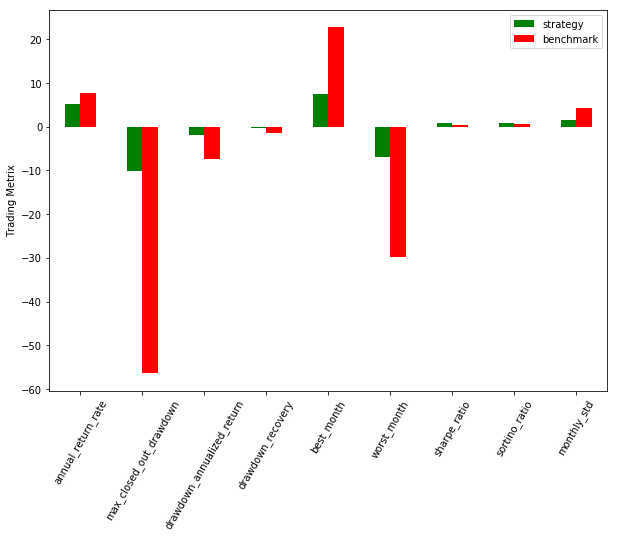

In [18]:
metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std')
df = pf.plot_bar_graph(stats, benchmark.stats, *metrics)
df